# Compare static vs dynamic communities

We believe that, when looking at reactions on an article, the reactions will be a derivation of some degree from the following/ignoring Graphs 

In [80]:
# automatically reload imports before executing any line in case you changed something
%load_ext autoreload
%autoreload 2


In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import read_graph
import viz
import utils

In [2]:
df = pd.read_csv("../data/raw/Following_Ignoring_Relationships_01052019_31052019.csv", delimiter=";")
fol_df = df[df["ID_CommunityConnectionType"]==1]
fol_df = fol_df[fol_df["ID_CommunityIdentity"] != fol_df["ID_CommunityIdentityConnectedTo"]] # remove self followers
G_fol = nx.from_pandas_edgelist(fol_df, source="ID_CommunityIdentity", target="ID_CommunityIdentityConnectedTo",
                               create_using=nx.DiGraph)
ign_df = df[df["ID_CommunityConnectionType"]==2]
G_ign = nx.from_pandas_edgelist(ign_df, source="ID_CommunityIdentity", target="ID_CommunityIdentityConnectedTo",
                               create_using=nx.DiGraph)

In [435]:
all_votes = utils.read_all_votes()
all_postings = utils.read_all_postings()
postings_inl = all_postings.query("ArticleChannel == 'Inland'")
postings_inl["ID_Article"].value_counts()[:-100]

2000103364196    12042
2000103990942     5173
2000103773909     4789
2000103772847     4290
2000103578888     3918
                 ...  
2000102742130       98
2000102552174       94
2000102609763       86
2000103276239       86
2000102519385       85
Name: ID_Article, Length: 227, dtype: int64

In [86]:
def create_graphs_from_article_id(article_id, all_votes, comm_min_size=3, ):
    art_selected = postings_inl[postings_inl["ID_Article"] == article_id]

    # this is not so easily feasible because the union of graphs changes the node_ids and will not be 
    # comparable to the "static" following/ignoring graphs anymore
    # G = read_graph.get_all_users_interactions(art_selected, all_votes, multi_di_graph=True, with_timestamp=True)
    g_pos = read_graph.get_users_voted_other_users(postings=art_selected, votes=all_votes, with_timestamp=True)
    g_neg = read_graph.get_users_voted_other_users(postings=art_selected, votes=all_votes, positive_vote=False, with_timestamp=True)
    #g_ = nx.union(g_pos, g_neg, rename=("p-", "h-"))


    g_pos_timerange = nx.get_edge_attributes(g_pos, "created_at").values()
    g_neg_timerange = nx.get_edge_attributes(g_neg, "created_at").values()
    pos_interval = (min(g_pos_timerange), max(g_pos_timerange))
    neg_interval = (min(g_neg_timerange), max(g_neg_timerange))

    com_pos = utils.get_communities(g_pos, min_size=comm_min_size, sort_by_sum_interactions=False)
    com_neg = utils.get_communities(g_neg, min_size=comm_min_size, sort_by_sum_interactions=False)
    
    return g_pos, g_neg, pos_interval, neg_interval, com_pos, com_neg

#Gs = utils.generate_snapshots_over_time(G, minutes=60, max_snapshots=150, interval=interval, include_final=False)


In [87]:
# "Welcher ""Austausch"" der Bevölkerung in Österreich tatsächlich stattfindet" = 2000103481296
article_id = 2000102742130

g_pos, g_neg, pos_interval, neg_interval, c_pos, c_neg = create_graphs_from_article_id(article_id, all_votes)

for c in c_pos:
    gp = g_pos.subgraph(c)
    gf = G_fol.subgraph(c)
    gi = G_ign.subgraph(c)
    
    n_nodes = len(c)
    tot_edges_possible = n_nodes*(n_nodes-1)/2
    
    n1 = len(gf.edges())
    n2 = len(gi.edges())
    
    print(tot_edges_possible, n1, n2)

435.0 5 0
253.0 0 0
253.0 0 0
153.0 0 0
66.0 0 0
28.0 0 0
28.0 0 0


In [53]:
import time
start = time.time()

for c in communities:
    gp = g_pos.subgraph(c)
    gf = G_fol.subgraph(c)
    gi = G_ign.subgraph(c)
    
    n_edges = len(c)
    tot_edges_possible = n_edges*(n_edges-1)/2
    
    for v in nx.optimize_graph_edit_distance(gp, gf, upper_bound=50):
    #for v in nx.optimize_edit_paths(gp,gf,upper_bound=5):
        minv = v
    edit_dist = minv
    print(edit_dist, tot_edges_possible, (edit_dist/tot_edges_possible))
end = time.time()
print("runtime: ", end-start)

9.0 435.0 0.020689655172413793
45.0 253.0 0.17786561264822134
41.0 253.0 0.16205533596837945
22.0 153.0 0.1437908496732026
12.0 66.0 0.18181818181818182
10.0 28.0 0.35714285714285715
9.0 28.0 0.32142857142857145
runtime:  0.13159608840942383


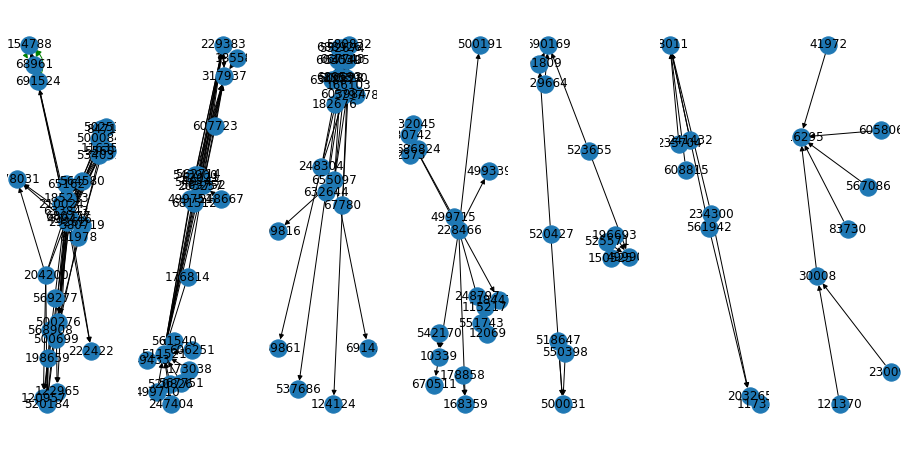

In [54]:
plt.figure(figsize=(16, 8))
lplot = len(communities)
ai = 1

for c in communities:
    gp = g_pos.subgraph(c)
    gf = G_fol.subgraph(c)
    gi = G_ign.subgraph(c)
    plt.subplot(1, lplot, ai)
    ai += 1
    positioning = nx.spring_layout(gp)
    #plt.figure(figsize=(8,4))
    nx.draw(gp, positioning, with_labels=True, arrows=True)
    nx.draw_networkx_edges(gf, positioning, edge_color="green", connectionstyle="arc3, rad=0.5" )
    nx.draw_networkx_edges(gi, positioning, edge_color="red", connectionstyle="arc3, rad=0.5" )

## Check for all articles that have more than 50 interactions

In [135]:
art_list = list(postings_inl["ID_Article"].value_counts().index[postings_inl["ID_Article"].value_counts().values>50])
#art_list = [2000102742130,2000103481296]
thresh = 0.05

for article in art_list:
    g_pos, g_neg, pos_interval, neg_interval, c_pos, c_neg = create_graphs_from_article_id(article, all_votes)
    
    for i in range(0, len(c_pos)):
        c = c_pos[i]
        gp = g_pos.subgraph(c)
        gf = G_fol.subgraph(c)
        gi = G_ign.subgraph(c)

        n_nodes = len(c)
        tot_edges_possible = n_nodes*(n_nodes-1)

        n1 = len(gf.edges())
        n2 = len(gi.edges())
        
        q = round(n1/tot_edges_possible, 5)
        
        #if n_fi>thresh:
        if q > thresh:
            print("Article: ", article, "community: ", i, "pos", n1, n2, q, tot_edges_possible)
        
    for i in range(0, len(c_neg)):
        c = c_neg[i]
        gn = g_neg.subgraph(c)
        gf = G_fol.subgraph(c)
        gi = G_ign.subgraph(c)

        n_nodes = len(c)
        tot_edges_possible = n_nodes*(n_nodes-1)

        n1 = len(gf.edges())
        n2 = len(gi.edges())

        q = round(n2/tot_edges_possible, 5)
        
        #if n1+n2>thresh:
        if q > thresh:
            print("Article: ", article, "community: ", i, "neg", n1, n2, q, tot_edges_possible)
            
    print("---")

Article:  2000103364196 community:  9 pos 7 0 0.58333 12
---
---
Article:  2000103773909 community:  9 pos 2 0 0.33333 6
---
Article:  2000103772847 community:  8 pos 6 0 0.5 12
---
---
---
---
Article:  2000103442116 community:  6 pos 50 0 0.45455 110
Article:  2000103442116 community:  10 pos 3 0 0.25 12
---
---
---
Article:  2000102973603 community:  10 pos 1 0 0.08333 12
Article:  2000102973603 community:  11 pos 3 0 0.25 12
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
Article:  2000103406915 community:  5 pos 25 0 0.10417 240
Article:  2000103406915 community:  6 pos 2 0 0.16667 12
---
---
Article:  2000103740730 community:  10 pos 11 0 0.91667 12
Article:  2000103740730 community:  12 pos 1 0 0.16667 6
Article:  2000103740730 community:  13 pos 6 0 1.0 6
---
---
---
Article:  2000102365833 community:  8 pos 3 0 0.5 6
---
---
---
Article:  2000103448721 community:  16 neg 0 1 0.08333 12
---
---
Article:  2000103294525 community:  9 pos 1 0 0.16667 6
---
---
---


KeyboardInterrupt: 

In [129]:
#2000103903057 ,c_pos[10] ## very good example
#2000102742130
article_id = 2000103903057 

g_pos, g_neg, pos_interval, neg_interval, c_pos, c_neg = create_graphs_from_article_id(article_id, all_votes)

com = c_pos[10]

gp = g_pos.subgraph(com)
gf = G_fol.subgraph(com)
gi = G_ign.subgraph(com)

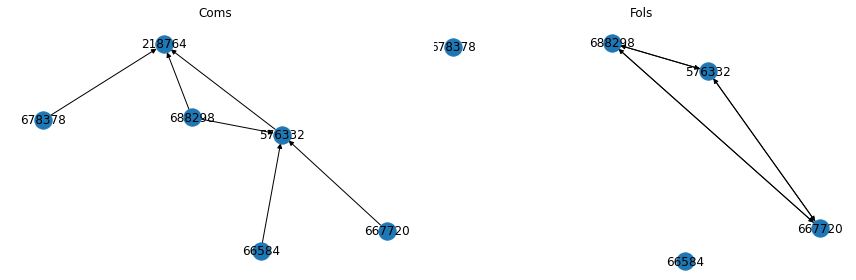

In [130]:
plt.figure(figsize=(12, 4))
limits = plt.axis("off")  # turn off axis

positioning = nx.spring_layout(gp)

plt.subplot(1, 2, 1)
nx.draw(gp, positioning, with_labels=True, arrows=True)
plt.title("Coms")

plt.subplot(1, 2, 2)
nx.draw(gf, positioning, with_labels=True, arrows=True)
plt.title("Fols")

plt.tight_layout()
plt.show()


[]

<Figure size 432x288 with 0 Axes>

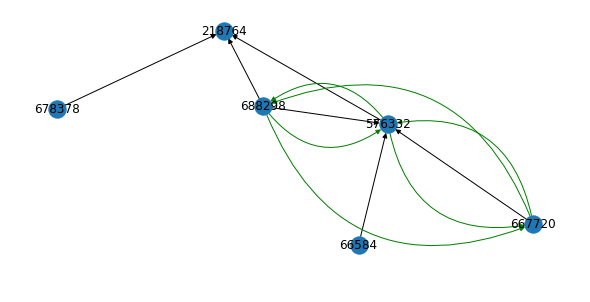

In [132]:
plt.clf()
#positioning = nx.spring_layout(gp)
plt.figure(figsize=(8,4))
nx.draw(gp, positioning, with_labels=True, arrows=True)
nx.draw_networkx_edges(gf, positioning, edge_color="green", connectionstyle="arc3, rad=0.5" )
nx.draw_networkx_edges(gi, positioning, edge_color="red", connectionstyle="arc3, rad=0.5" )


## Vice Versa, Following/Ignoring Graph to Articles

In [5]:
from networkx.algorithms import community

communities_F = list(community.greedy_modularity_communities(nx.Graph(G_fol)))
print(len(communities_F))
communities_I = list(community.greedy_modularity_communities(nx.Graph(G_ign)))
print(len(communities_I))

528
158


<AxesSubplot:>

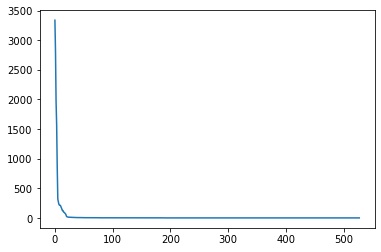

In [36]:
lensf = [len(l) for l in communities_F]
lensi = [len(l) for l in communities_I]
sns.lineplot(data=lensf)
#nx.draw(G_fol.subgraph(communities_F[10]))

In [49]:
# only take communities with more than 3 nodes
top_F = communities_F[:len(list(filter(lambda x: x>3 ,lens)))]
top_I = communities_F[:len(list(filter(lambda x: x>3 ,lens)))]

In [188]:
print(len(postings_inl["ID_Article"].value_counts()))
print(len(list(postings_inl["ID_Article"].value_counts().index[postings_inl["ID_Article"].value_counts().values>50])))

len(list(postings_inl["ID_Article"].value_counts().index))
art_selected["ArticlePublishingDate"].value_counts().index[0]
#min(art_selected["PostingCreatedAt"])
#max(art_selected["PostingCreatedAt"])

327
245


'2019-05-28 20:00:00.00'

## Create Re-Usable Dataset for the analysis of static communities and their edges in each article 

In [218]:
# Create .csv for reuse

thresh = 0.0

# art_list = list(postings_inl["ID_Article"].value_counts().index[postings_inl["ID_Article"].value_counts().values>50]) #over 50
# art_list = list(postings_inl["ID_Article"].value_counts().index) #all
art_list = list(postings_inl["ID_Article"].value_counts().index[postings_inl["ID_Article"].value_counts().values>25])

res_df = pd.DataFrame(columns=["Article","ArticlePublishingDate","Community","n_edges","total_edges_possible","quotient"])

from tqdm import tqdm
for article in tqdm(art_list):
    art_selected = postings_inl[postings_inl["ID_Article"] == article]
    pubdate = art_selected["ArticlePublishingDate"].value_counts().index[0] #majority publishing date (in case there would be non-unique values)
    g_interactions = read_graph.get_all_users_interactions(postings=art_selected, votes=all_votes, with_timestamp=True, multi_di_graph=True, salvage_original_node_ids=True)
    for i in range(0,len(top_F)):
        c = top_F[i]
        g_ = g_interactions.subgraph(c)

        n_nodes = len(c)
        tot_edges_possible = n_nodes*(n_nodes-1)

        n_edges = len(g_.edges())

        q = round(n_edges/tot_edges_possible, 5)

        #if n_fi>thresh:
        #if q > thresh:
        #    print("Article: ", article, "community: ", i, n_edges, q, tot_edges_possible)
        res_df = res_df.append(
                        pd.Series([article, pubdate, i, n_edges, tot_edges_possible, q], index=res_df.columns),
                        ignore_index=True)
    #print("---")
res_df.to_csv("../data/res_inland.csv")

100%|██████████| 275/275 [1:21:47<00:00, 17.85s/it]


In [261]:
res_inland = pd.read_csv("../data/res_inland.csv")
res_inland = res_inland.drop("Unnamed: 0", axis=1)
res_inland.head()

,Article,ArticlePublishingDate,Community,n_edges,total_edges_possible,quotient
0,2000103364196,2019-05-17 18:19:06.19,0,3844,11125560,0.00035
1,2000103364196,2019-05-17 18:19:06.19,1,1287,7921410,0.00016
2,2000103364196,2019-05-17 18:19:06.19,2,1824,3843560,0.00047
3,2000103364196,2019-05-17 18:19:06.19,3,667,2463330,0.00027
4,2000103364196,2019-05-17 18:19:06.19,4,90,738740,0.00012


<Figure size 1728x720 with 0 Axes>

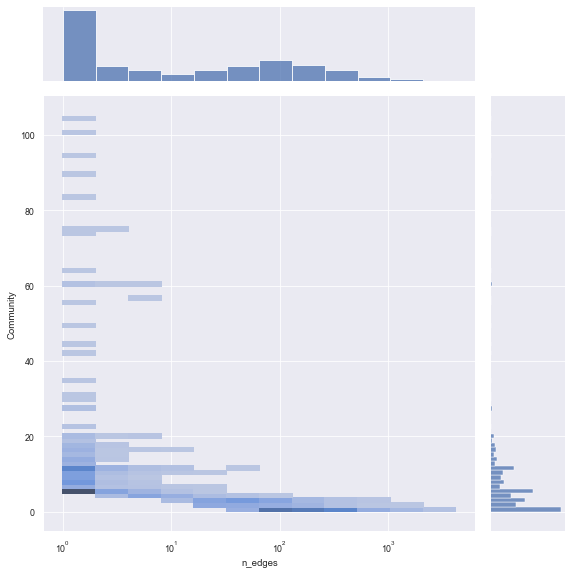

In [837]:
plt.figure(figsize=(24, 10))

sns.set_theme()
sns.set_context("paper")
sns.jointplot(data=res_inland[res_inland["quotient"]!=0],
            x="n_edges", y="Community",
            log_scale=(True,False),
            height=8,
            kind="hist", palette="magma",
        )

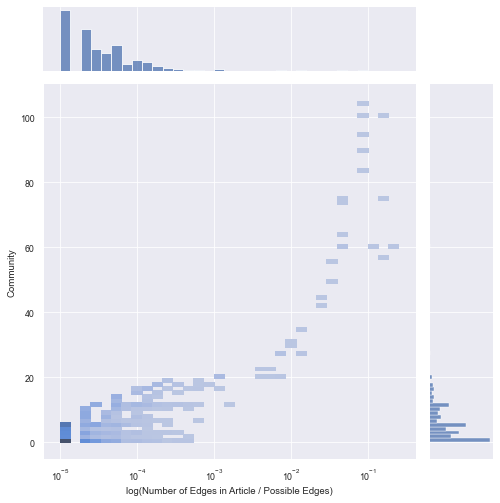

In [838]:
#sns.displot(res_inland[res_inland["quotient"]!=0]["quotient"], log_scale=True, kde=True)
#fig, ax = plt.subplots(figsize=(12,7))
sns.set_theme()
sns.set_context("paper")
p = sns.jointplot(data=res_inland[res_inland["quotient"]!=0],
            x="quotient", y="Community",
            log_scale=(True,False),
            height=7,
            kind="hist", palette="magma",
        )
p.set_axis_labels("log(Number of Edges in Article / Possible Edges)", "Community")
#p.set_xlabel("Number of Edges in Article / Possible Edges")


In [437]:
#res_inland[res_inland["quotient"]!=0]["Community"].value_counts() #
res_inland[res_inland["n_edges"]!=0]["Community"].value_counts()

1      273
0      269
3      256
2      242
4      174
5      114
6       94
8       67
10      63
12      60
11      55
9       52
7       45
14      32
13      23
18      22
15      18
17      18
20      17
16      10
61       8
27       8
19       7
22       2
101      2
35       2
75       2
23       2
60       1
95       1
90       1
84       1
74       1
64       1
56       1
57       1
50       1
45       1
42       1
31       1
30       1
28       1
105      1
Name: Community, dtype: int64

### Detailed look at community 61

In [380]:
articles_61 = res_inland.query("Community == 61 and n_edges != 0").Article.values
res_inland.query("Community == 61 and n_edges != 0")


,Article,ArticlePublishingDate,Community,n_edges,total_edges_possible,quotient
6541,2000102979060,2019-05-12 13:23:39.14,61,5,20,0.25
6865,2000103642110,2019-05-22 21:09:07.00,61,1,20,0.05
9781,2000103707683,2019-05-24 06:00:00.00,61,1,20,0.05
13345,2000102463625,2019-05-03 14:01:53.00,61,1,20,0.05
13453,2000103985049,2019-05-30 08:00:01.07,61,4,20,0.20
17881,2000103083608,2019-05-14 09:02:40.75,61,1,20,0.05
24469,2000102519385,2019-05-04 20:22:25.70,61,2,20,0.10
26521,2000102449356,2019-05-03 11:42:55.00,61,1,20,0.05


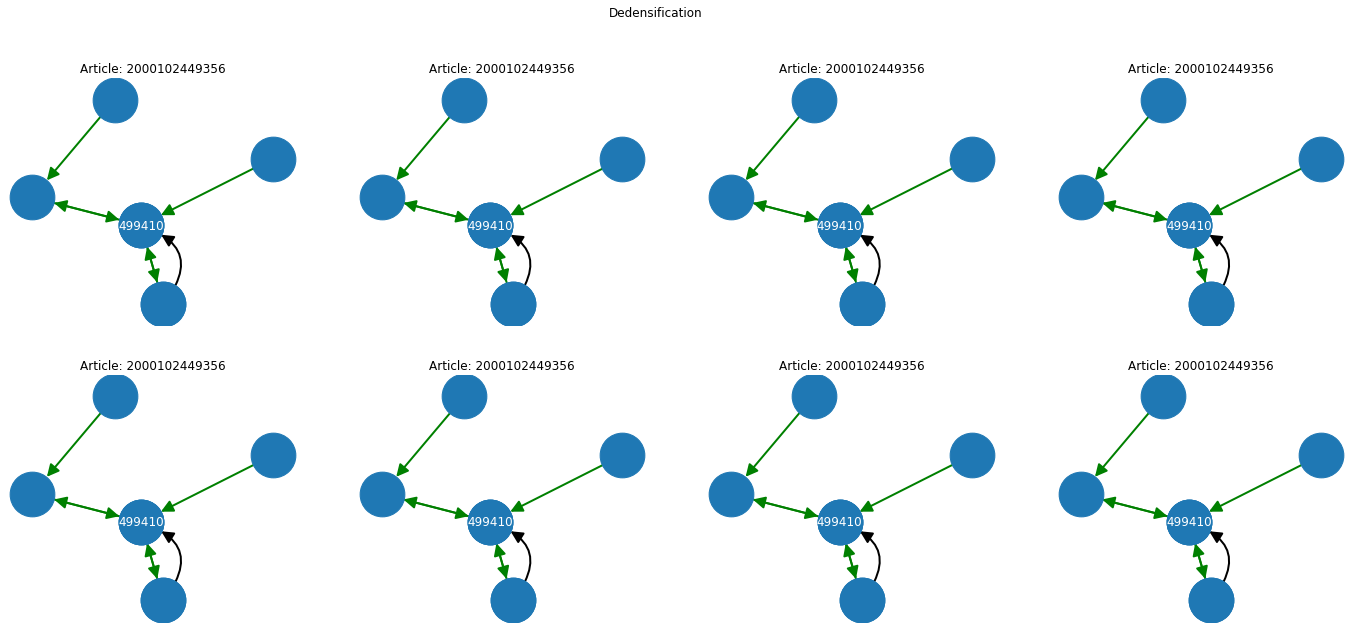

In [461]:
plt.figure(figsize=(24, 10))

plt.suptitle("Dedensification")

for i in range(1,9):
    plt.subplot(2,4,i)
    drawopts = dict(arrowsize=25, node_size=2000, width=2)
    nx.draw(c_g, positions_, with_labels=False, edge_color="green", **drawopts)
    nx.draw(c_i, positions_, edge_color="black", connectionstyle="arc3, rad=0.7", **drawopts)
    nx.draw(c_g.subgraph([499410]), positions_, with_labels=True, font_color="white", **drawopts)
    plt.title(''.join(["Article: ", str(a)]))


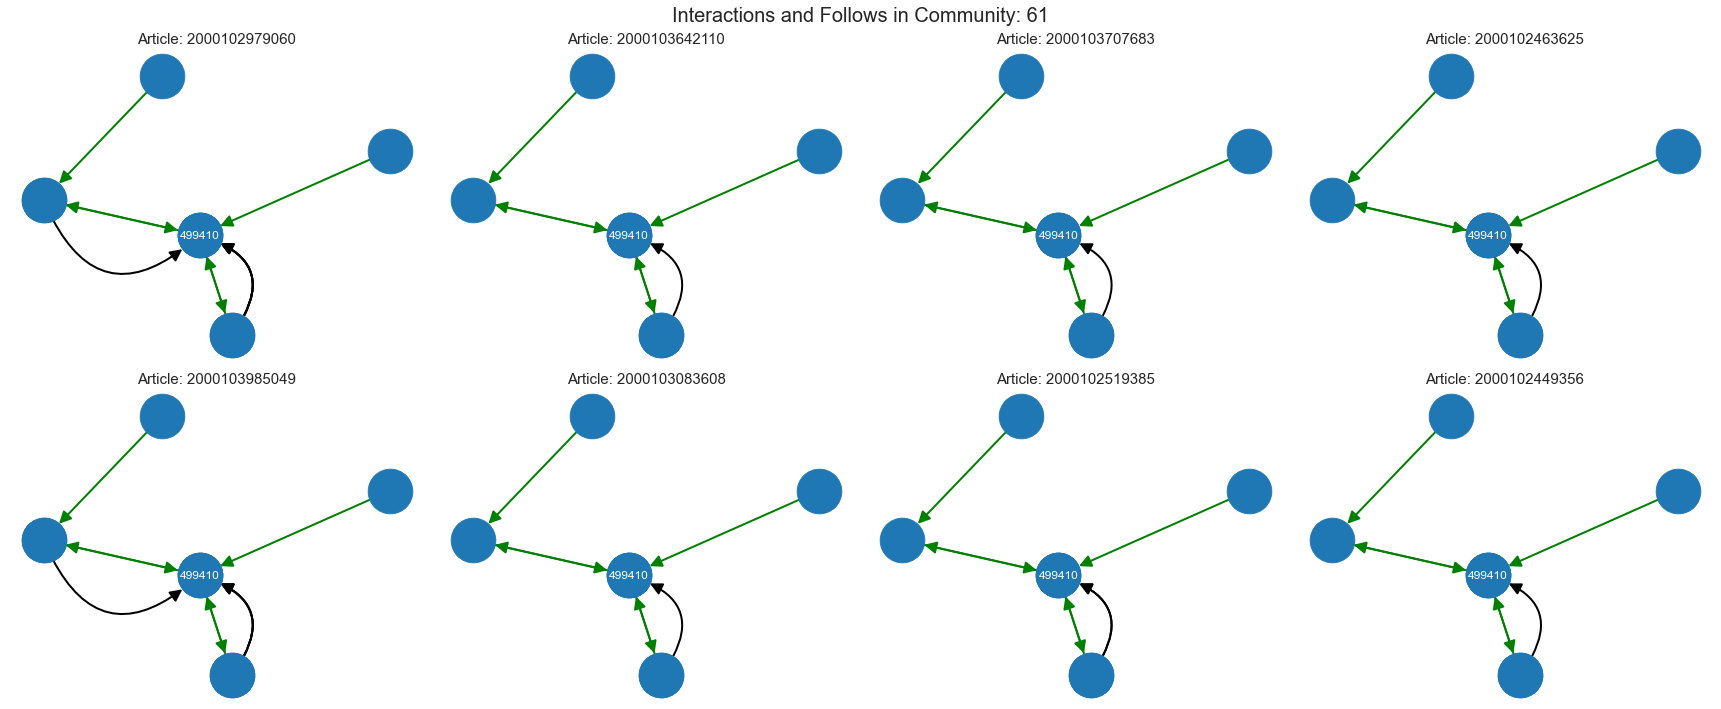

In [982]:
plt.figure(figsize=(24, 10))
lplot = len(articles_61)
ai = 1

thiscom = 61
c = top_F[thiscom]
c_g = G_fol.subgraph(c)
#positions_ = nx.spring_layout(c_g)
positions_ = {186567: [ 0.11049361, -1.],
 41354: [0.76706174, 0.35861193],
 249582: [-0.67369133, -0.00406133],
 499410: [-0.02426247, -0.26490587],
 21663: [-0.17960154,  0.91035527]}

drawopts = dict(arrowsize=25, node_size=2000, width=2)
pre_selected_art = postings_inl[postings_inl['ID_Article'].isin(articles_61)]

plt.suptitle(''.join(["Interactions and Follows in Community: ", str(thiscom)]), size=20)

for a in articles_61:
    art_selected = pre_selected_art[pre_selected_art["ID_Article"] == a]
    g_interactions = read_graph.get_all_users_interactions(postings=art_selected, votes=all_votes, with_timestamp=True, multi_di_graph=True, salvage_original_node_ids=True)

    c_i = g_interactions.subgraph(c)
    
    plt.subplot(2,4,ai)
    ai += 1
    nx.draw(c_g, positions_, with_labels=False, edge_color="green", **drawopts)
    nx.draw(c_i, positions_, edge_color="black", connectionstyle="arc3, rad=0.7", **drawopts)
    nx.draw(c_g.subgraph([499410]), positions_, with_labels=True, font_color="white", **drawopts)
    plt.title(''.join(["Article: ", str(a)]), size=15)

plt.tight_layout()
plt.savefig("../report/figures/static_dynamic_comm_61.png")

### Detailed look at Community 20

In [465]:
articles_20 = res_inland.query("Community == 20 and n_edges != 0").Article.values
print("Number of articles: ", len(articles_20))
print("Number of users: ", len(top_F[20]))
res_inland.query("Community == 20 and n_edges != 0")


Number of articles:  17
Number of users:  30


,Article,ArticlePublishingDate,Community,n_edges,total_edges_possible,quotient
20,2000103364196,2019-05-17 18:19:06.19,20,5,870,0.00575
452,2000103578888,2019-05-21 21:15:06.44,20,1,870,0.00115
560,2000103928932,2019-05-28 06:00:00.00,20,4,870,0.00460
992,2000103519155,2019-05-20 21:46:49.60,20,7,870,0.00805
2828,2000103406915,2019-05-18 22:41:21.00,20,1,870,0.00115
3908,2000103294525,2019-05-16 21:25:28.00,20,1,870,0.00115
5096,2000103582477,2019-05-22 06:00:00.00,20,1,870,0.00115
5636,2000102836720,2019-05-09 18:00:00.00,20,1,870,0.00115
6284,2000103026244,2019-05-13 11:43:31.00,20,1,870,0.00115
6500,2000102979060,2019-05-12 13:23:39.14,20,1,870,0.00115


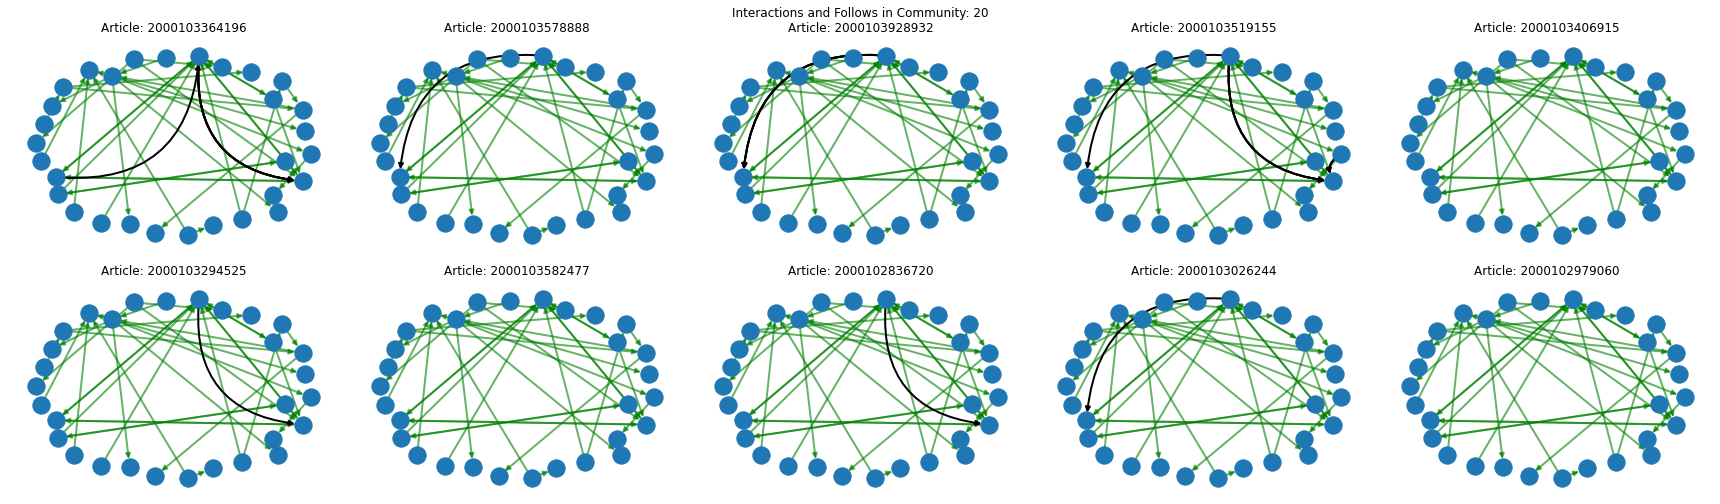

In [585]:
thiscom = 20

plt.figure(figsize=(24, 14))

c = top_F[thiscom]
c_g = G_fol.subgraph(c)

ai = 1

#positions_ = nx.spring_layout(c_g, k=100)
positions_ = {504066: [-0.99175096,  0.02381006], 230276: [-0.44735161,  0.76493852], 69766: [-0.83574049, -0.55278645], 606215: [-0.87938492,  0.43514878], 555916: [-0.13913714, -0.97991635], 37263: [ 0.78906375, -0.17965966], 502802: [ 0.48109155, -0.82117661], 651540: [0.77088298, 0.70830145], 247843: [-0.32160012, -0.87629743], 499236: [-0.52569138, -0.86514966], 670118: [ 0.97611339, -0.1043632 ], 557481: [-0.93416714,  0.22938175], 505133: [0.91557513, 0.39120217], 577332: [-0.84829617, -0.36002129], 632760: [-0.79961251,  0.64047492], 103096: [-0.72267853, -0.74666559], 534970: [-0.61417341,  0.83306757], 511549: [-0.05885679,  0.96786411], 539847: [0.33712403, 0.86813441], 174409: [ 0.09650125, -1.        ], 515914: [ 0.91585945, -0.40594193], 691662: [-0.95443489, -0.18619228], 244445: [0.54925483, 0.8144464 ], 511969: [ 0.73784381, -0.74489318], 602856: [ 0.7068246 , -0.56293695], 545641: [-0.2926488 ,  0.95240686], 114795: [ 0.27330058, -0.89367149], 578671: [0.70578914, 0.50789509], 174201: [0.1759391 , 0.99045126], 543998: [0.93436126, 0.15214871]}
#positions_ = nx.kamada_kawai_layout(c_g, dim=2)
#positions_ = nx.planar_layout(c_g)
#positions_ = nx.spiral_layout(c_g, scale=100000)

drawopts = dict(node_size=250, width=2)
pre_selected_art = postings_inl[postings_inl['ID_Article'].isin(articles_20)]

plt.suptitle(''.join(["Interactions and Follows in Community: ", str(thiscom)]))

for a in articles_20[:10]:
    art_selected = pre_selected_art[pre_selected_art["ID_Article"] == a]
    g_interactions = read_graph.get_all_users_interactions(postings=art_selected, votes=all_votes, with_timestamp=True, multi_di_graph=True, salvage_original_node_ids=True)

    plt.subplot(4,5,ai)
    ai += 1
    c_i = g_interactions.subgraph(c)
    nx.draw(c_g, positions_, alpha=0) # only draw the subplot for the titles and alignment to take place, but make "invisible" with alpha=0
    nx.draw_networkx_nodes(c_g, positions_, )
    nx.draw_networkx_edges(c_g, positions_, edge_color="green", alpha=0.6, **drawopts)
    nx.draw_networkx_edges(c_i, positions_, edge_color="black", connectionstyle="arc3, rad=0.5", **drawopts)
    plt.title(''.join(["Article: ", str(a)]))


plt.tight_layout()

In [590]:
art_selected = pre_selected_art[pre_selected_art["ID_Article"] == 2000103406915]
g_interactions = read_graph.get_all_users_interactions(postings=art_selected, votes=all_votes, with_timestamp=True, multi_di_graph=True, salvage_original_node_ids=True)

c_i = g_interactions.subgraph(c)
#postings_inl[postings_inl["ID_Article" == 2000103406915]]

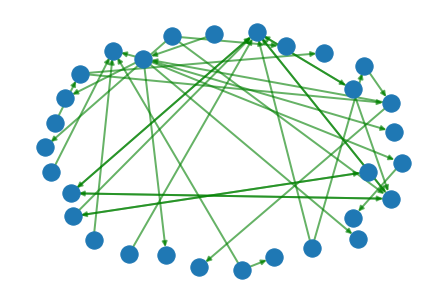

In [604]:
nx.draw(c_g, positions_, alpha=0) # only draw the subplot for the titles and alignment to take place, but make "invisible" with alpha=0
nx.draw_networkx_nodes(c_g, positions_, )
nx.draw_networkx_edges(c_g, positions_, edge_color="green", alpha=0.6, **drawopts)
nx.draw_networkx_edges(c_i, positions_, edge_color="black", connectionstyle="arc3, rad=0.5", **drawopts)
nx.draw_networkx_edges(c_i, positions_, edge_color="red", edgelist=elist, style="dashed")

## Average Time a post receives interactions

In [755]:
res_inland["ArticlePublishingDate"].max()

'2019-05-31 18:37:49.56'

5 days 15:19:31.044822630


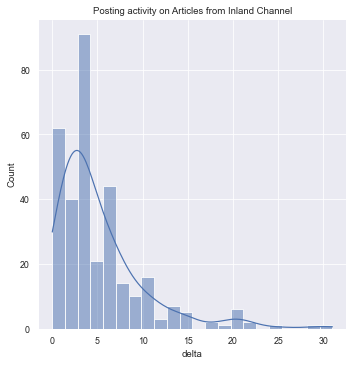

In [775]:
sns.set_theme()
sns.set_context("paper")

foo = pd.DataFrame()
foo["ID"] = postings_inl[["PostingCreatedAt", "ID_Article"]].groupby("ID_Article").min().index
foo["min"] = pd.to_datetime(postings_inl[["PostingCreatedAt", "ID_Article"]].groupby("ID_Article").min().values.flatten())
foo["max"] = pd.to_datetime(postings_inl[["PostingCreatedAt", "ID_Article"]].groupby("ID_Article").max().values.flatten())
foo["delta"] = foo["max"] - foo["min"]
sns.displot(foo["delta"].apply(lambda x: x.days), kde=True)
plt.title("Posting activity on Articles from Inland Channel")
print(foo["delta"].mean())

## Community Interactions over time

In [960]:
res_inland.query("Community==0").sort_values("n_edges", ascending=False)[:10]


,Article,ArticlePublishingDate,Community,n_edges,total_edges_possible,quotient
0,2000103364196,2019-05-17 18:19:06.19,0,3844,11125560,0.00035
216,2000103773909,2019-05-24 18:10:27.00,0,2505,11125560,0.00023
108,2000103990942,2019-05-28 20:00:00.00,0,1981,11125560,0.00018
756,2000103442116,2019-05-19 19:01:46.55,0,1609,11125560,0.00014
1080,2000102973603,2019-05-12 11:01:05.83,0,1547,11125560,0.00014
972,2000103519155,2019-05-20 21:46:49.60,0,1546,11125560,0.00014
432,2000103578888,2019-05-21 21:15:06.44,0,1488,11125560,0.00013
2160,2000103289061,2019-05-16 21:00:00.00,0,1340,11125560,0.00012
1512,2000102732845,2019-05-08 14:00:17.00,0,1254,11125560,0.00011
1188,2000104086108,2019-05-31 06:00:00.00,0,1168,11125560,0.00010


In [972]:
c_1_arts = res_inland.query("Community==0").sort_values("n_edges", ascending=False)[:10].Article.values

postings_inl[postings_inl["ID_Article"].isin(c_1_arts)][["ID_Article", "ArticlePublishingDate", "ArticleTitle"]].sort_values("ArticlePublishingDate").drop_duplicates()

,ID_Article,ArticlePublishingDate,ArticleTitle
318476,2000102732845,2019-05-08 14:00:17.00,Vilimsky finanzierte mit Steuergeld überwiegen...
307146,2000102973603,2019-05-12 11:01:05.83,"Kurz will ""Bevormundung"" durch Brüssel beenden..."
20703,2000103289061,2019-05-16 21:00:00.00,"Polizisten warteten bei Razzia zwölf Minuten, ..."
110996,2000103364196,2019-05-17 18:19:06.19,Strache soll Staatsaufträge für Wahlkampfspend...
47243,2000103442116,2019-05-19 19:01:46.55,Kurz will Entlassung Kickls vorschlagen – Rück...
132707,2000103519155,2019-05-20 21:46:49.60,Kurz droht nach Absetzung Kickls ein Misstraue...
152179,2000103578888,2019-05-21 21:15:06.44,Dem Expertenkabinett des Kanzlers droht ein sc...
217098,2000103773909,2019-05-24 18:10:27.00,"Sebastian Kurz: ""Einzelfälle haben mich viel K..."
309752,2000103990942,2019-05-28 20:00:00.00,"Sebastian Kurz: ""SPÖ und FPÖ haben ein gemeins..."
363068,2000104086108,2019-05-31 06:00:00.00,Halbe und andere Wahrheiten von Ex-Kanzler Kurz


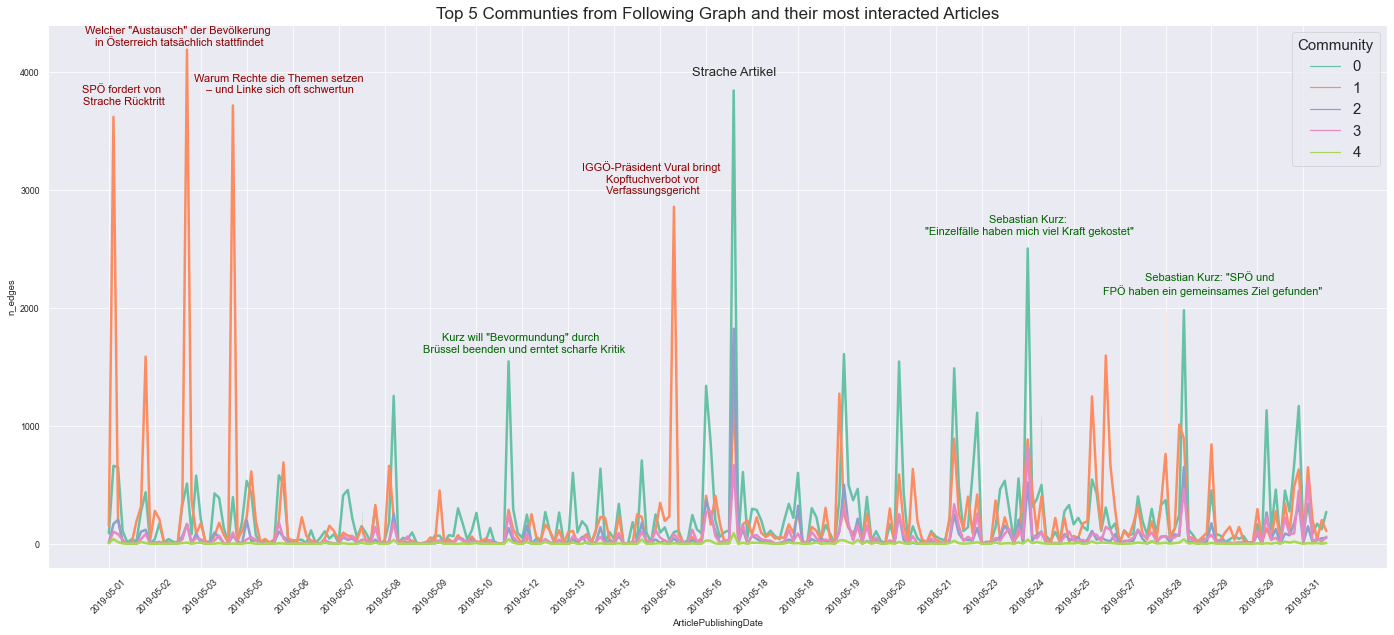

In [979]:
sns.set_theme()
sns.set_context("paper")

plt.figure(figsize=(24, 10))

p = sns.lineplot(data=res_inland[res_inland["Community"].isin([0,1,2,3,4])].sort_values(by="ArticlePublishingDate"),
             x="ArticlePublishingDate",
             y="n_edges",
             hue="Community",
             linewidth=2.5,
             palette="Set2",
             sort=False,
                )
p.set_xticks(p.get_xticks()[::10])
plt.xticks(rotation=45)
xlabels = ['2019-05-01', '2019-05-02', '2019-05-03', '2019-05-05', '2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10', '2019-05-12', '2019-05-13', '2019-05-15', '2019-05-16', '2019-05-16', '2019-05-18', '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21', '2019-05-23', '2019-05-24', '2019-05-25', '2019-05-27', '2019-05-28', '2019-05-29', '2019-05-29', '2019-05-31']
p.set_xticklabels(xlabels)
plt.legend(loc=0, prop={'size': 15}, title="Community", title_fontsize=15)
#p.set_xticklabels(p.get_xticklabels()[::10])
#plt.axvline("2019-05-31 18:37:49.56", 0.04, 1, color="black", label="test")
plt.text("2019-05-17 18:19:06.19", 4000,
         "Strache Artikel", size=13,
         ha="center", va="center",
         rotation=0, verticalalignment='center')
plt.text(3, 3800,
         "SPÖ fordert von \n Strache Rücktritt", size=11,
         ha="center", va="center",
         color="darkred",
         rotation=0, verticalalignment='center')
plt.text(15, 4300,
         "Welcher \"Austausch\" der Bevölkerung\n in Österreich tatsächlich stattfindet", size=11,
         ha="center", va="center",
         color="darkred",
         rotation=0, verticalalignment='center')
plt.text(37, 3900,
         "Warum Rechte die Themen setzen\n – und Linke sich oft schwertun", size=11,
         ha="center", va="center",
         color="darkred",
         rotation=0, verticalalignment='center')
plt.text(118, 3100,
         "IGGÖ-Präsident Vural bringt\n Kopftuchverbot vor\n Verfassungsgericht", size=11,
         ha="center", va="center",
         color="darkred",
         rotation=0, verticalalignment='center')
plt.text(90, 1700,
         "Kurz will \"Bevormundung\" durch \n Brüssel beenden und erntet scharfe Kritik", size=11,
         ha="center", va="center",
         color="darkgreen",
         rotation=0, verticalalignment='center')
plt.text(200, 2700,
         "Sebastian Kurz:\n \"Einzelfälle haben mich viel Kraft gekostet\"", size=11,
         ha="center", va="center",
         color="darkgreen",
         rotation=0, verticalalignment='center')
plt.text(240, 2200,
         "Sebastian Kurz: \"SPÖ und \n FPÖ haben ein gemeinsames Ziel gefunden\"", size=11,
         ha="center", va="center",
         color="darkgreen",
         rotation=0, verticalalignment='center')


plt.title("Top 5 Communties from Following Graph and their most interacted Articles", size=17)
plt.savefig("../report/figures/top5_comms_labeled.png")